In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import re

In [24]:
# Load results from JSON files
results_dir = "../results"

def libname_of_path(path):
    return re.search(".*lib(.*)\.so.\d", path).group(1)


with open(f"{results_dir}/baseline.json") as fp_baseline:
    res = dict()
    raw = json.load(fp_baseline)
    outer_iterations = raw['dlopen-dlclose']['outer-iterations']
    inner_iterations = raw['dlopen-dlclose']['inner-iterations']
    for lib in raw['dlopen-dlclose']['libraries']:
        libname = libname_of_path(lib['library-path'])
        lib.pop('library-path')
        res[libname] = lib
        
    baseline = pd.concat([pd.DataFrame(res[key]).assign(libname=key).set_index('libname')
                          for key in res.keys()]) / (outer_iterations * inner_iterations)

with open(f"{results_dir}/sandbox.json") as fp_sandbox:
    res = dict()
    raw = json.load(fp_sandbox)
    assert raw['dlopen_sandbox-dlclose']['outer-iterations'] == outer_iterations
    assert raw['dlopen_sandbox-dlclose']['inner-iterations'] == inner_iterations
    for lib in raw['dlopen_sandbox-dlclose']['libraries']:
        libname = libname_of_path(lib['library-path'])
        lib.pop('library-path')
        res[libname] = lib
        
    sandbox = pd.concat([pd.DataFrame(res[key]).assign(libname=key).set_index('libname')
                         for key in res.keys()]) / (outer_iterations * inner_iterations)

In [25]:
libnames = set(baseline.index.values).intersection(sandbox.index.values)
print(f"Libraries: {libnames}")
counters = set(baseline.columns).intersection(sandbox.columns)
print(f"Counters: {counters}")

Libraries: {'globvar', 'helloworld', 'z_nofio'}
Counters: {'unhalted-cycles', 'branches', 'branch-mispredicts'}


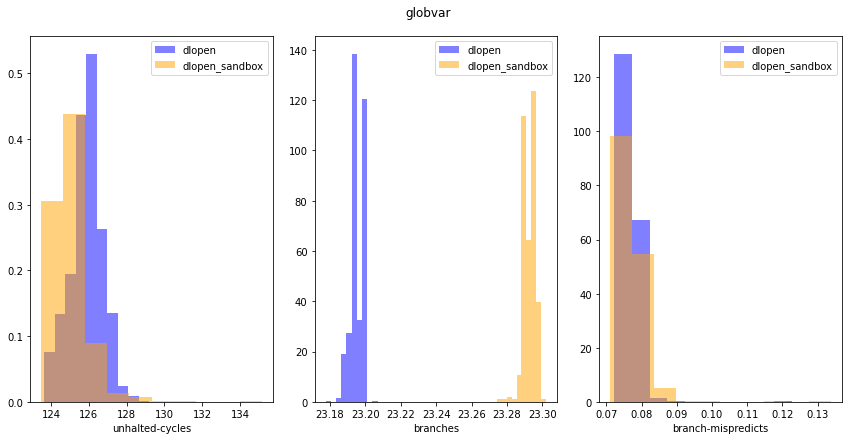

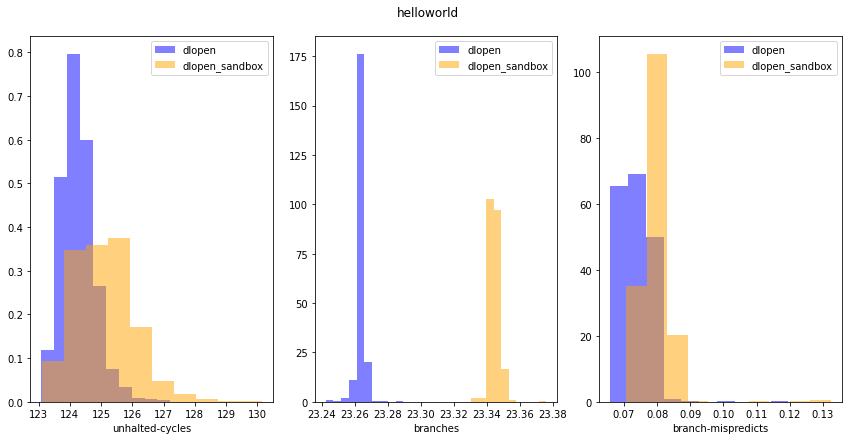

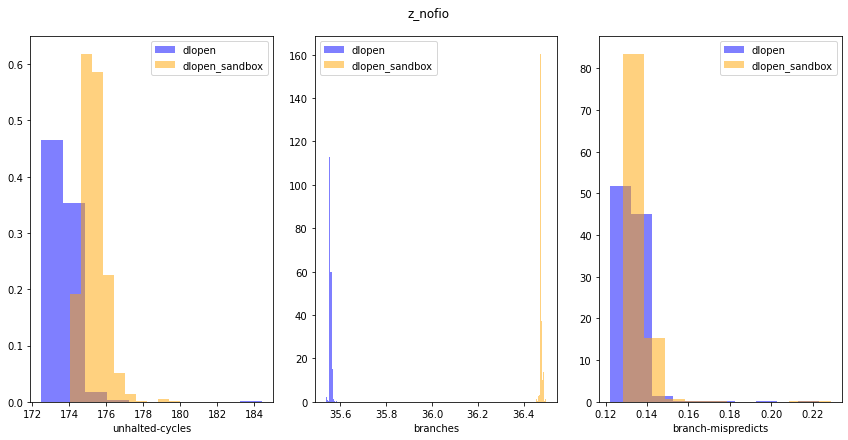

In [26]:
for libname in sorted(libnames):
    fig, axs = plt.subplots(ncols=len(libnames), figsize=(12, 6))
    
    fig.suptitle(libname)
    fig.tight_layout()
    
    for counter, ax in zip(counters, axs.ravel()):
        ax.hist(baseline.loc[libname, counter], density=True, histtype='stepfilled', color='blue', alpha=.5, label='dlopen')
        ax.hist(sandbox.loc[libname, counter], density=True, histtype='stepfilled', color='orange', alpha=.5, label='dlopen_sandbox')
        ax.set_xlabel(counter)
        ax.legend()
    
plt.show()